In [ ]:
!pip install cartoframes
!pip install pysal
!pip install git+https://github.com/cartodb/cartoframes.git#egg=cartoframes
import cartoframes
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pysal
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
import graphviz

%matplotlib inline
sns.set_style("whitegrid")

# Input CARTO account credentials


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cartodb/cartoframes.git to /tmp/pip-install-z7708hn7/cartoframes_31a1a49c5da94777ac0cd3b47613f58e
  Running command git clone -q https://github.com/cartodb/cartoframes.git /tmp/pip-install-z7708hn7/cartoframes_31a1a49c5da94777ac0cd3b47613f58e


Data Used:
    
   - LION https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-lion.page
   - NYPD Collisions (only 2017 and 2018) https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95
   - TomTom Probe Count and MultiNet
   - Waze jams feed
    

# Table of Contents

1. [Collision data exploration](#1)  
    1.1 [Count of collisions by hour](#1.1)  
    1.2 [Count by contributing factor](#1.2)  
    1.3 [Count by vehicle type and vehicle type cleaning](#1.3)
2. [Joining collision point data to street line data](#2)  
    2.1 [Data preparation for LION dataset](#2.1)  
    2.2 [Find nearest road segment id to each collision with query](#2.2)  
    2.3 [Join back to street line data and fill NAs](#2.3)
3. [Collision data exploration with TomTom probe count data](#3)  
    3.1 [Data prep TomTom and collisions](#3.1)  
    3.2 [Collision rate by hour](#3.2)
4. [Local Moran's I spatial autocorrelation](#4)  
    4.1 [Build street network from LION and create spatial weight](#4.1)  
    4.2 [Local Moran's I with `pysal`](#4.2)  
5. [Decision tree feature importances](#5)  
    5.1 [Single decision tree and output graph](#5.1)  
    5.2 [Random forest and output feature importances](#5.2)  
6. [Collision data exploration with Waze traffic jams data](#6)  
    6.1 [Clean and union Waze jams](#6.1)  
    6.2 [Find collisions that occur during jams](#6.2)  
    6.3 [Fatality/injury rates of collisions during jams](#6.3)

# 1. Collision data exploration
<a id='1'></a>

## 1.1 Count of collisions by hour
<a id='1.1'></a>

In [ ]:
# Read in collision data from CARTO account
collisions = pd.read_csv('https://data.cityofnewyork.us/resource/h9gi-nx95.csv')

NameError: ignored

In [ ]:
collisions.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
0,2021-09-11T00:00:00.000,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,2022-03-26T00:00:00.000,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,2022-06-29T00:00:00.000,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,2021-09-11T00:00:00.000,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"\n, \n(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,2021-12-14T00:00:00.000,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"\n, \n(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


In [ ]:

collisions['date'] = collisions['crash_date'].str[:10]
collisions['date']
hour = []
for i in range(0,len(collisions)):
  hour.append(int(collisions.iloc[i].crash_time.split(":")[0]))
collisions['hour'] = hour

In [ ]:
# Create hour, weekday, and weekend separation
import datetime as dt
collisions['date'] = pd.to_datetime(collisions['date'], errors='coerce')
collisions['weekday'] = collisions['date'].dt.dayofweek
collisions['notweekend'] = collisions['weekday'].isin([0,1,2,3,4])
collisions.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,collision_id,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,date,weekday,notweekend,hour
0,2021-09-11T00:00:00.000,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,4455765,Sedan,Sedan,NaN,NaN,NaN,2021-09-11,5,False,2
1,2022-03-26T00:00:00.000,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,4513547,Sedan,NaN,NaN,NaN,NaN,2022-03-26,5,False,11
2,2022-06-29T00:00:00.000,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN,2022-06-29,2,True,6
3,2021-09-11T00:00:00.000,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"\n, \n(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,4456314,Sedan,NaN,NaN,NaN,NaN,2021-09-11,5,False,9
4,2021-12-14T00:00:00.000,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"\n, \n(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,4486609,NaN,NaN,NaN,NaN,NaN,2021-12-14,1,True,8


In [ ]:
weekday_count = collisions[collisions['notweekend']==True].groupby('hour')['borough'].count()
weekend_count = collisions[collisions['notweekend']==False].groupby('hour')['borough'].count()

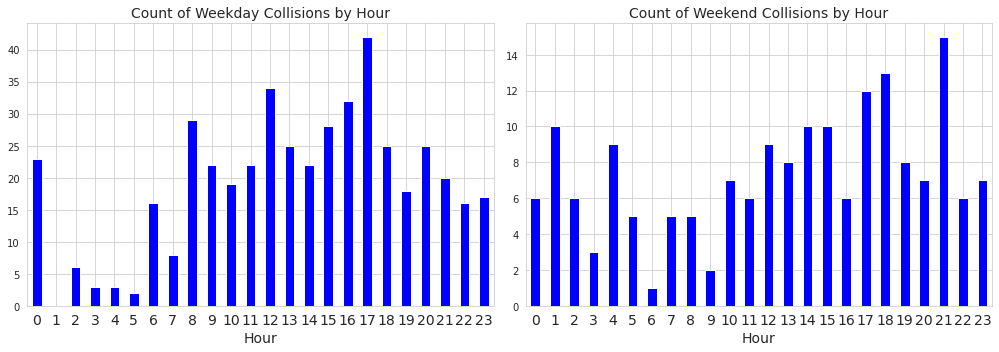

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
weekday_count.plot(kind='bar', color='blue')
plt.title('Count of Weekday Collisions by Hour', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Hour',fontsize=14)

plt.subplot(122)
weekend_count.plot(kind='bar', color='blue')
plt.title('Count of Weekend Collisions by Hour', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Hour',fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
weekday_count = collisions[collisions['notweekend']==True].groupby('weekday')['borough'].count()
weekend_count = collisions[collisions['notweekend']==False].groupby('weekday')['borough'].count()

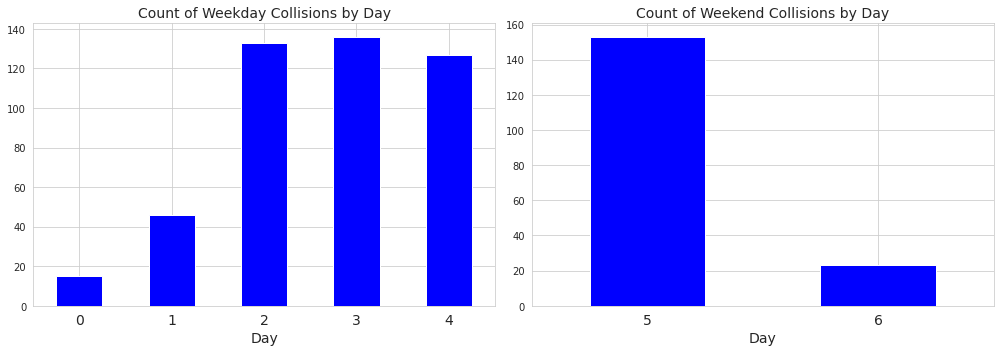

In [ ]:
weekday_count = collisions[collisions['notweekend']==True].groupby('weekday')['borough'].count()
weekend_count = collisions[collisions['notweekend']==False].groupby('weekday')['borough'].count()
plt.figure(figsize=(14, 5))
plt.subplot(121)
weekday_count.plot(kind='bar', color='blue')
plt.title('Count of Weekday Collisions by Day', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Day',fontsize=14)

plt.subplot(122)
weekend_count.plot(kind='bar', color='blue')
plt.title('Count of Weekend Collisions by Day', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Day',fontsize=14)

plt.tight_layout()
plt.show()

## 1.2 Count by contributing factor

<a id='1.2'></a>

In [ ]:
contrib_data = (collisions.groupby('contributing_factor_vehicle_1')['borough']
                         .count()
                         .sort_values(ascending=False)[0:10])

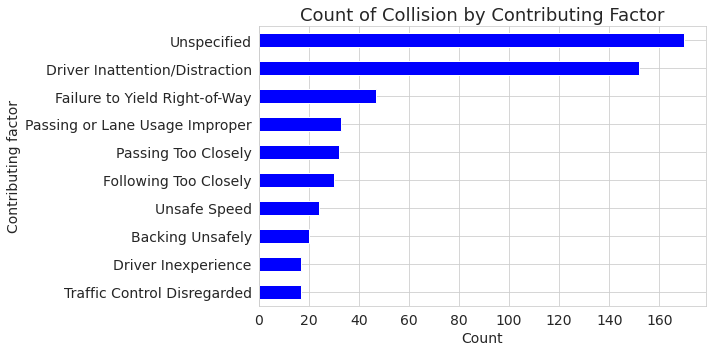

In [ ]:
contrib_data[::-1].plot(kind='barh', figsize=(10,5), color='blue')
plt.xlabel('Count', fontsize=14)
plt.title('Count of Collision by Contributing Factor', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('Contributing factor', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

## 1.3 Count by vehicle type and vehicle type cleaning

<a id='1.3'></a>

In [ ]:
collisions.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,collision_id,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,date,weekday,notweekend,hour
0,2021-09-11T00:00:00.000,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,4455765,Sedan,Sedan,NaN,NaN,NaN,2021-09-11,5,False,2
1,2022-03-26T00:00:00.000,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,4513547,Sedan,NaN,NaN,NaN,NaN,2022-03-26,5,False,11
2,2022-06-29T00:00:00.000,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN,2022-06-29,2,True,6
3,2021-09-11T00:00:00.000,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"\n, \n(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,4456314,Sedan,NaN,NaN,NaN,NaN,2021-09-11,5,False,9
4,2021-12-14T00:00:00.000,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"\n, \n(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,4486609,NaN,NaN,NaN,NaN,NaN,2021-12-14,1,True,8


In [ ]:
vehicle_codes = collisions['vehicle_type_code1'].unique()

In [ ]:
# Make dictionaries for classification classifications
bikes = ['BICYCLE',
         'SCOOTER',
         'PEDICAB',
         'EBIKE',
         'Scoot',
         'PEDIC']
motorcycle = ['MOTORCYCLE',
              'MD',
              'MS',
              'MOTOR',
              'MOPED',
              'Motor']
passengercars = ['PASSENGER VEHICLE',
                 'PAS',
                 'CONV',
                 'LL',
                 'SPORT UTILITY / STATION WAGON',
                 'subn']
bus = ['BU',
       'BUS',
       'OML',
       'bus',
       'SCHOO',
       'Schoo',
       'Bus',
       'schoo']
emergency = ['FIRE TRUCK',
             'AM',
             'GOV V',
             'AMBULANCE',
             'AMBUL',
             'ambul',
             'FIRET',
             'fire',
             'Fire',
             'Ambul',
             'FDNY',
             'EMS',
             'AMB',
             'ABULA']
hire = ['TAXI', 'CB','CAB', 'LIVER']
delivery = ['POSTA', 'DELIV', 'USPS', 'deliv', 'posta', 'DELV']
trucks_tankers_garbage = ['truck',
                          'TK',
                          'TR',
                          'FB',
                          'DS',
                          'DP',
                          'TN',
                          'GG',
                          'TRUCK',
                          'AR',
                          'cargo',
                          'TRAIL',
                          'BR',
                          'Comme',
                          'TOW T',
                          'BOX T',
                          'TRACT',
                          'tk',
                          'DUMP',
                          'UTIL',
                          'Util',
                          'Ice C',
                          'COMME',
                          'Tow t',
                          'sanit',
                          'tank',
                          'DUMPS',
                          'SANIT',
                          'dsny',
                          'UHAUL',
                          'SEMI',
                          'CARGO',
                          'FREIG',
                          'trail']
construction = ['TT',
                'CM',
                'LF',
                'BACKH',
                'GE/SC',
                'Pavin',
                'Road',
                'cemen',
                'FORKL',
                'BOBCA',
                'forkl',
                'bobca',
                'Crane']
pickup = ['PICK-UP TRUCK', 'PK', 'PICKU']
horse = ['horse']
suvvan = ['Van', 'VAN', 'van', 'VN', 'RF', 'SPRIN' ,'UTILI', 'VT', 'VAN T','van t', 'VAN/T']

In [ ]:
classified = bikes+motorcycle+passengercars+bus+emergency+hire+delivery+trucks_tankers_garbage+construction+pickup+horse+suvvan

# Make list of everything else (unknown) vehicle codes
unknown = list(set(vehicle_codes) - set(classified))

collisions['vehicle_type_code_1_class'] = collisions['vehicle_type_code1']\
                                            .replace(passengercars, 'Passenger Vehicles')\
                                            .replace(bikes, 'Bikes, Pedicabs, Scooters')\
                                            .replace(motorcycle, 'Motorcycles and Mopeds')\
                                            .replace(trucks_tankers_garbage, 'Trucks, Garbage, Tankers')\
                                            .replace(bus, 'Buses')\
                                            .replace(emergency, 'Emergency (Ambulance, Fire)')\
                                            .replace(delivery, 'Delivery')\
                                            .replace(hire, 'For Hire (Taxi)')\
                                            .replace(construction, 'Construction')\
                                            .replace(pickup, 'Pick-up Trucks')\
                                            .replace(horse, 'Horse')\
                                            .replace(suvvan, 'SUVs and Vans')\
                                            .replace(unknown, 'Unknown')

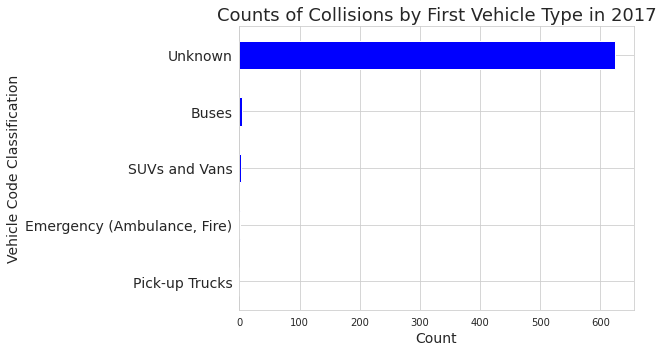

In [ ]:
(collisions.groupby('vehicle_type_code_1_class')['borough']
          .count()
          .sort_values()
          .plot(kind='barh', color='b', figsize=(9,5)))
plt.title('Counts of Collisions by First Vehicle Type in 2017', fontsize=18)
plt.ylabel('Vehicle Code Classification', fontsize=14)
plt.xlabel('Count',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=10)
plt.tight_layout()
# plt.savefig('collisions_vehicle_type.png')

# 2. Joining collision point data to street line data  

<a id='2'></a>

## 2.1 Data preparation for LION dataset
<a id='2.1'></a>

In [ ]:
lion_lines = pd.read('lion_lines_full', decode_geom=True)

AttributeError: ignored

In [ ]:
# take only relevant columns from lion dataset
data = lion_lines[['featuretyp','bikelane','rw_type','bike_trafdir','nonped',
                    'number_park_lanes','number_total_lanes','number_travel_lanes', 'posted_speed',
                    'snow_priority','streetwidth_max','trafdir','shape_length', 'geometry', 'streetcode',
                  'nodeidfrom','nodeidto']]

NameError: ignored

In [ ]:
# Remove non-vehicle roads
nonvehicle_roads = ['3','1','2','5','7','8','9','W','F']
data_vehicles = data[~data['featuretyp'].isin(nonvehicle_roads)]

# Change posted speed to numeric
posted_speeds = ['25', '  ', '50', '20', '40', '30', '35', '45', '15']
numeric_speeds = [25, None, 50, 20, 40, 30, 35, 45, 15]
data_vehicles.posted_speed.replace(to_replace=posted_speeds, value=numeric_speeds, inplace=True)

# change number_park_lanes, number_total_lanes, number_travel_lanes to numeric
park_lanes = data_vehicles.number_park_lanes.unique()
new_park_lanes = [None, 2, 1, 4]
total_lanes = data_vehicles.number_total_lanes.unique()
new_total_lanes = [1, None, 3, 2, 4, 6, 8, 7, 5, 9, 16, 12, 10]
number_travel_lanes = data_vehicles.number_travel_lanes.unique()
new_travel_lanes = [1, None, 2, 4, 3, 6, 5, 8, 16, 7, 12, 10, 9]

data_vehicles.number_park_lanes.replace(to_replace=park_lanes, value=new_park_lanes, inplace=True)
data_vehicles.number_total_lanes.replace(to_replace=total_lanes, value=new_total_lanes, inplace=True)
data_vehicles.number_travel_lanes.replace(to_replace=number_travel_lanes, value=new_travel_lanes, inplace=True)

# fix travel or parking lanes to 0 if there are total lanes
# condition if number_park_lanes is NaN
condition = (~data_vehicles['number_total_lanes'].isna() & data_vehicles['number_park_lanes'].isna())
data_vehicles.loc[condition, 'number_park_lanes'] = 0

# add in no-bike lane
data_vehicles.bikelane.replace(to_replace='  ', value='No Bike Lane', inplace=True)
data_vehicles.bike_trafdir.replace(to_replace='  ', value='No bike_trafdir', inplace=True)

# add in pedestrian-friendly nonped category
data_vehicles.nonped.replace(to_replace=' ', value='ped', inplace=True)

# fix snow priority with NA category
data_vehicles.snow_priority.replace(to_replace=' ', value='no_priority', inplace=True)

In [ ]:
data_clean = data_vehicles.dropna()
cc.write(data_clean, 'lion_clean', overwrite=True)

## 2.2 Find nearest road segment id for each collision

<a id='2.2'></a>

In [ ]:
find_nearest_query = '''
SELECT
  roads.cartodb_id as cartodb_id,
  count(collisions.cartodb_id) as collision_count,
  sum(collisions.number_of_persons_injured) as sum_injuries,
  sum(collisions.number_of_persons_killed) as sum_fatalities,
  sum(collisions.number_of_cyclist_injured) as sum_cyclist_injured,
  sum(collisions.number_of_cyclist_killed) as sum_cyclist_killed,
  sum(collisions.number_of_motorist_injured) as sum_motorists_injured,
  sum(collisions.number_of_motorist_killed) as sum_motorists_killed,
  sum(collisions.number_of_pedestrians_injured) as sum_pedestrian_injured,
  sum(collisions.number_of_pedestrians_killed) as sum_pedestrian_killed
FROM
  (SELECT cartodb_id, the_geom, the_geom_webmercator, number_of_cyclist_injured,
        number_of_cyclist_killed,
        number_of_motorist_injured,
        number_of_motorist_killed,
        number_of_pedestrians_injured,
        number_of_pedestrians_killed,
        number_of_persons_injured,
        number_of_persons_killed
   FROM nypd_collisions_2017) AS collisions
CROSS JOIN LATERAL
  (SELECT cartodb_id, the_geom, the_geom_webmercator
   FROM {street} as roads
   ORDER BY collisions.the_geom_webmercator <-> the_geom_webmercator
   LIMIT 1) AS roads
GROUP BY roads.cartodb_id
'''

In [ ]:
nearest_road = cc.query(find_nearest_query.format(street='lion_clean'))

## 2.3 Join back to street network and fill NA values

<a id='2.3'></a>

In [ ]:
road_segments = cc.query('select * from lion_clean', decode_geom=True)
road_segments.reset_index(inplace=True)
collision_join = road_segments.join(nearest_road,
                                    on='cartodb_id',
                                    how='left',
                                    lsuffix='_left')

In [ ]:
collision_join = cc.read('collision_join')

In [ ]:
collision_join.collision_count.fillna(value=0, inplace=True)
collision_join.sum_injuries.fillna(value=0, inplace=True)
collision_join.sum_fatalities.fillna(value=0, inplace=True)
collision_join.sum_cyclist_injured.fillna(value=0, inplace=True)
collision_join.sum_cyclist_killed.fillna(value=0, inplace=True)
collision_join.sum_motorists_injured.fillna(value=0, inplace=True)
collision_join.sum_motorists_killed.fillna(value=0, inplace=True)
collision_join.sum_pedestrian_injured.fillna(value=0, inplace=True)
collision_join.sum_pedestrian_killed.fillna(value=0, inplace=True)

In [ ]:
# Write to CARTO account

collision_join.drop(['the_geom','cartodb_id'], axis=1, inplace=True, errors='ignore')
cc.write(collision_join, 'collision_join', overwrite=True, encode_geom=True)

In [ ]:
# Map collision rates

cc.map(layers=[cartoframes.QueryLayer('''select *,
                                        collision_count/ST_Length(the_geom) as rate
                                        from collision_join''',
                                      color={'column': 'rate',
                                              'scheme': cartoframes.styling.temps(4)}),
               cartoframes.BaseMap(source='dark')],
      interactive=False)

# 3. Collision data exploration with TomTom probe count data  
<a id='3'></a>

## 3.1 Data prep TomTom and collisions

<a id='3.1'></a>

In [ ]:
tomtom_road = gpd.GeoDataFrame.from_file('tomtom_joined/joined.shp')

In [ ]:
weekday_volume = tomtom_road[['WD_1',
 'WD_2',
 'WD_3',
 'WD_4',
 'WD_5',
 'WD_6',
 'WD_7',
 'WD_8',
 'WD_9',
 'WD_10',
 'WD_11',
 'WD_12',
 'WD_13',
 'WD_14',
 'WD_15',
 'WD_16',
 'WD_17',
 'WD_18',
 'WD_19',
 'WD_20',
 'WD_21',
 'WD_22',
 'WD_23',
 'WD_24']].sum()
weekend_volume = tomtom_road[['WE_1',
 'WE_2',
 'WE_3',
 'WE_4',
 'WE_5',
 'WE_6',
 'WE_7',
 'WE_8',
 'WE_9',
 'WE_10',
 'WE_11',
 'WE_12',
 'WE_13',
 'WE_14',
 'WE_15',
 'WE_16',
 'WE_17',
 'WE_18',
 'WE_19',
 'WE_20',
 'WE_21',
 'WE_22',
 'WE_23',
 'WE_24']].sum()

weekday_volume.index = list(range(0,24))
weekend_volume.index = list(range(0,24))

## 3.2 Collision rate by hour

<a id='3.2'></a>

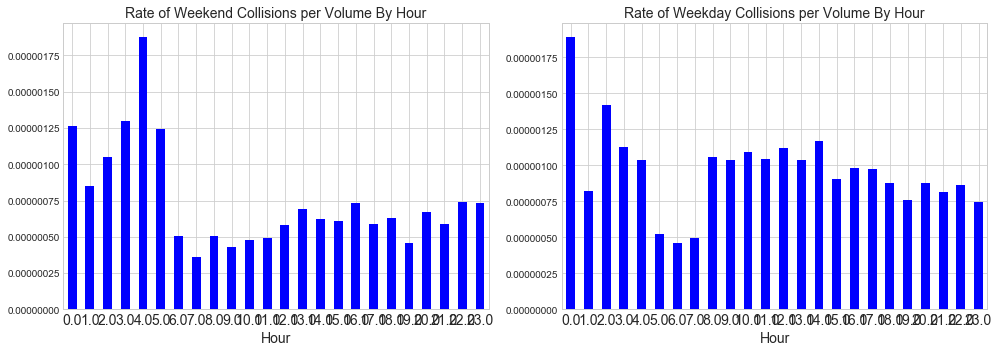

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
(weekend_count/weekend_volume).plot(kind='bar', color='blue')
plt.title('Rate of Weekend Collisions per Volume By Hour', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Hour',fontsize=14)

plt.subplot(122)
(weekday_count/weekday_volume).plot(kind='bar', color='blue')
plt.title('Rate of Weekday Collisions per Volume By Hour', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Hour',fontsize=14)

plt.tight_layout()
plt.show()

# 4. Local Moran's I spatial autocorrelation  
<a id='4'></a>

## 4.1 Build street network from LION and create spatial weight object
<a id='4.1'></a>

In [ ]:
# We are building the street network based on the nodeidfrom and nodeidto
# A different method would be to use the geometries
collision_join[['nodeidfrom','nodeidto']] = collision_join[['nodeidfrom','nodeidto']].astype('int')
collision_join['node_a'] =  collision_join[['nodeidfrom','nodeidto']].min(axis=1)
collision_join['node_b'] =  collision_join[['nodeidfrom','nodeidto']].max(axis=1)
# Remove duplicates segments, this removes some road information
collision_join_unique = collision_join[~collision_join.duplicated(subset=['node_a', 'node_b'], keep='first')]


In [ ]:
# Set up dictionaries for look ups
a_b_dictionary= {}
b_a_dictionary= {}
for node_id, dest_ids in collision_join_unique[['node_a', 'node_b']].groupby('node_a'):
    a_b_dictionary[node_id]= list(dest_ids.node_b.values)
for node_id, dest_ids in collision_join_unique[['node_a', 'node_b']].groupby('node_b'):
    b_a_dictionary[node_id]= list(dest_ids.node_a.values)

In [ ]:
# Build street network in format ready for pysal weights
street_network = {}
for start_node, first_nodes in a_b_dictionary.items():
    for first_node in first_nodes:
        connected_lines = []
        if first_node in a_b_dictionary.keys():
            for second_node in a_b_dictionary[first_node]:
                connected_line = (min((first_node, second_node)),max((first_node, second_node)))
                connected_lines.append(connected_line)
        elif first_node in b_a_dictionary.keys():
            for second_node in b_a_dictionary[first_node]:
                connected_line = (min((first_node, second_node)),max((first_node, second_node)))
                connected_lines.append(connected_line)
        street_network[(min((start_node, first_node)),max((start_node, first_node)))] = list(set(connected_lines))

for start_node, first_nodes in b_a_dictionary.items():
    for first_node in first_nodes:
        connected_lines = []
        if first_node in b_a_dictionary.keys():
            for second_node in b_a_dictionary[first_node]:
                connected_line = (min((first_node, second_node)),max((first_node, second_node)))
                connected_lines.append(connected_line)
        elif first_node in a_b_dictionary.keys():
            for second_node in a_b_dictionary[first_node]:
                connected_line = (min((first_node, second_node)),max((first_node, second_node)))
                connected_lines.append(connected_line)
        if street_network[(min((start_node, first_node)),max((start_node, first_node)))]:
                already_connected = street_network[(min((start_node, first_node)),max((start_node, first_node)))]
                already_connected.extend(connected_lines)
                street_network[(min((start_node, first_node)),max((start_node, first_node)))] = list(set(already_connected))
        else:
            street_network[(min((start_node, first_node)),max((start_node, first_node)))] = connected_lines

In [ ]:
# Create weight object
weights = pysal.weights.weights.W(street_network)

## 4.2 Local Moran's I with `pysal`

<a id='4.2'></a>

In [ ]:
collision_join_unique.set_index(keys=['node_a', 'node_b'], inplace=True)
collision_join_unique['collision_rate'] = collision_join_unique['collision_count']/collision_join_unique['shape_length']

In [ ]:
w = weights
b = collision_join_unique.shape_length
e = collision_join_unique.collision_rate
lm = pysal.esda.moran.Moran_Local(e, w)

In [ ]:
# Calculate the spatial lag
yl  = pysal.lag_spatial(w, e)

# Z-Score standardisation
yt   = (e - e.mean())/e.std()
ylt  = (yl - yl.mean())/yl.std()

quad = np.zeros(yt.shape)
quad[np.bitwise_and(ylt > 0, yt > 0)]=1 # HH
quad[np.bitwise_and(ylt > 0, yt < 0)]=2 # LH
quad[np.bitwise_and(ylt < 0, yt < 0)]=3 # LL
quad[np.bitwise_and(ylt < 0, yt > 0)]=4 # HL

In [ ]:
colors = np.where(quad==1,'r', '-')
colors[quad==2] = 'b'
colors[quad==3] = 'g'
colors[quad==4] = 'yellow'

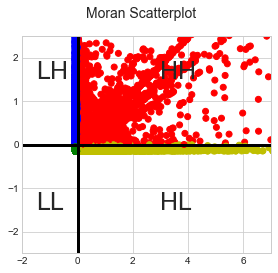

In [ ]:
fig, ax = plt.subplots()
plt.scatter(yt, ylt, c=colors)

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.axvline(0, c='k', alpha=1, linewidth=3)
plt.axhline(0, c='k', alpha=1, linewidth=3)
ax.set_xlim(-2, 7)
ax.set_ylim(-2.5, 2.5)
plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)

plt.suptitle("Moran Scatterplot", fontsize=14)

plt.show()

In [ ]:
collision_join_unique['lm_p_sim'] = lm.p_sim
collision_join_unique['lm_q'] = lm.q

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
cc.write(collision_join_unique, 'localmorans_result', overwrite=True)

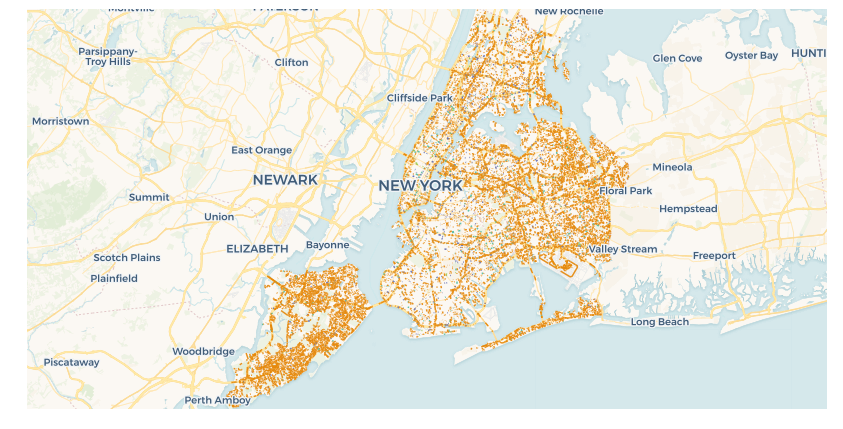

In [ ]:
# Map Local Moran's I results

cc.map(layers=[cartoframes.QueryLayer('select *, lm_q::text as lm_q_cat from localmorans_result where lm_p_sim < 0.01',
                                       color={'column': 'lm_q_cat',
                                              'scheme': cartoframes.styling.vivid(4)})],
       interactive=False
      )

# 5. Decision tree feature importances  

<a id='5'></a>

## 5.1 Single decision tree and output graph  

<a id='5.1'></a>

In [ ]:
# Add in density measurement
data = collision_join.copy()
data['density'] = data['collision_count']/data['shape_length']
y = data['density']
x = data[['bike_trafdir', 'featuretyp', 'nonped', 'number_park_lanes',
       'number_travel_lanes', 'posted_speed',
       'snow_priority', 'streetwidth_max', 'trafdir', 'bikelane']]

In [ ]:
x['bike_trafdir'].replace(['TF','FT'], 'one_way', inplace=True)
x['trafdir'].replace(['W','A'], 'one_way', inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [ ]:
clf = DecisionTreeRegressor(max_depth=3)
clf = clf.fit(np.asarray(pd.get_dummies(x)), np.asarray(y))

In [ ]:
# re-label with human readable labels according to LION metadata
labels = ['Number Parking Lanes',
'Number Travel Lanes',
'Posted Speed',
'Street Width',
'No Bike Traffic',
'Two Way Bike Traffic',
'One Way Bike Traffic',
'Other Type Street',
'Private Street',
'CCO Street',
'Pedestrian Not Recommended',
'Non-Pedestrian',
'Pedestrian Friendly',
'Critical Snow Priority',
'Haulster Snow Removal',
'Non-Critical Snow Priority',
'Non-DSNY Snow Priority',
'No Snow Priority',
'Pedestrian Path',
'Two-way Traffic Flow',
'One-way Traffic Flow',
'Separate Greenway Bike Lane',
'Striped Bike Lane',
'Signed Bicycle Route',
'Connecting segments bike lane',
'Combo greenway and striped bike lane',
'Combo striped and signed bike lane',
'Stairs (bike lane)',
'Combo greenway and signed bike lane',
'Combo striped and separated bike lane',
'Combo signed and separated bike lane',
'Combo signed and striped bike lane',
'No bike lane']

In [ ]:
dot_data = export_graphviz(clf, max_depth=3, out_file=None, feature_names=labels)

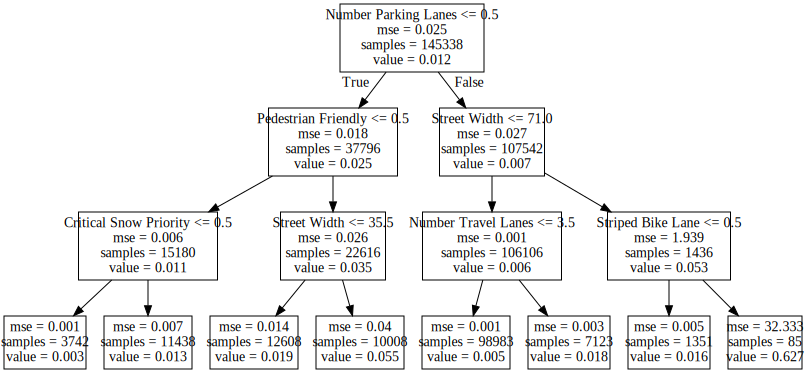

In [ ]:
graph = graphviz.Source(dot_data)
graph

## 5.2 Random forest and output feature importances

<a id='5.2'></a>

In [ ]:
regr = RandomForestRegressor(n_estimators=100, min_samples_split=5, max_depth=5, random_state=0)
regr.fit(pd.get_dummies(x), y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

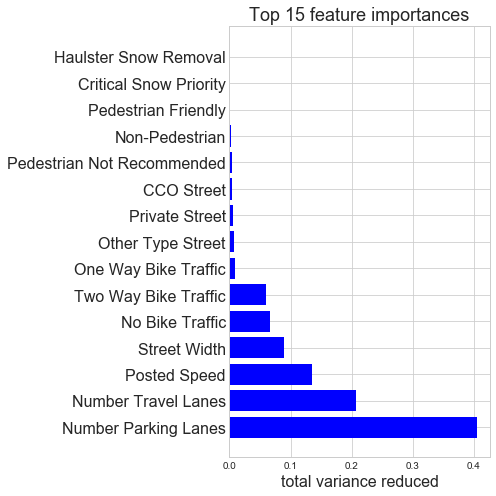

In [ ]:
importances = regr.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the top 10 feature importances of the forest
plt.figure(figsize=(7,7))
plt.title("Top 15 feature importances", size=18)
plt.barh(range(pd.get_dummies(x).shape[1])[0:15], importances[indices][0:15],
       color="b", align="center")
plt.yticks(range(pd.get_dummies(x).shape[1])[0:15], labels[0:15], size=16)
plt.xlabel('total variance reduced', size=16)
# plt.ylim([-1, pd.get_dummies(x).shape[1]])
plt.tight_layout()
# plt.show()

# 6. Collision data exploration with Waze traffic jams data  

<a id='6'></a>

## 6.1 Clean and union Waze jams  

<a id='6.1'></a>

In [ ]:
flatten_jams = '''
SELECT
     ROW_NUMBER() OVER () AS cartodb_id, uuid, min(georss_date) as min_georss, max(georss_date) as max_georss,
     ST_Multi(ST_Union(nyc_waze_data_jams.the_geom)) as the_geom,
     ST_Transform(ST_Multi(ST_Union(nyc_waze_data_jams.the_geom)),
                  3857) as the_geom_webmercator
FROM nyc_waze_data_jams
GROUP BY uuid
'''

In [ ]:
cc.query(flatten_jams, table_name='flatten_jams')

## 6.2 Find collisions that occur during jams  

<a id='6.2'></a>

In [ ]:
# use nypd collisions for april/may 2018 (same period of waze data)
# fix timestamp column format

datetime = '''
UPDATE nypd_motor_vehicle_collisions_april_may
SET datetime = to_timestamp(date||' '||time,'MM/DD/YYYY FMHH24:FMMI:FMSS' )
'''

In [ ]:
jams_geom_collision = '''
SELECT collisions.the_geom,
       collisions.the_geom_webmercator,
       collisions.location,
       collisions.on_street_name,
       collisions.contributing_factor_vehicle_1,
       collisions.datetime,
       flatten_jams.uuid,
       flatten_jams.min_georss,
       flatten_jams.max_georss,
       number_of_cyclist_injured,
       number_of_cyclist_killed,
       number_of_motorist_injured,
       number_of_motorist_killed,
       number_of_pedestrians_injured,
       number_of_pedestrians_killed,
       number_of_persons_injured,
       number_of_persons_killed
FROM "michellemho-carto".nypd_motor_vehicle_collisions_april_may as collisions, flatten_jams
WHERE (datetime, INTERVAL '1 minute') OVERLAPS (flatten_jams.min_georss, flatten_jams.max_georss)
AND ST_DWithin(collisions.the_geom_webmercator, flatten_jams.the_geom_webmercator, 10)
'''

jam_collisions = cc.query(jams_geom_collision, table_name = 'collisions_during_jams')

In [ ]:
cc.query(datetime)

In [ ]:
# only use collisions that occur in same time period of waze data

collision_during_studyperiod_query = '''
SELECT collisions.*
FROM "michellemho-carto".nypd_motor_vehicle_collisions_april_may as collisions
WHERE (datetime, INTERVAL '0 minute') OVERLAPS (DATE '2018-04-26T11:05:00Z', DATE '2018-05-09T23:54:00Z')
'''
studyperiod_collisions = cc.query(collision_during_studyperiod_query)
studyperiod_collisions.reset_index(inplace=True)

# isolate the ids of jams that overlap

collisions_during_jams_id_query = '''
SELECT collisions.cartodb_id
FROM "michellemho-carto".nypd_motor_vehicle_collisions_april_may as collisions, flatten_jams
WHERE (datetime, INTERVAL '1 minute') OVERLAPS (flatten_jams.min_georss, flatten_jams.max_georss)
AND ST_DWithin(collisions.the_geom_webmercator, flatten_jams.the_geom_webmercator, 10)
'''
collisions_during_jams_id = cc.query(collisions_during_jams_id_query)

In [ ]:
jam_collisions = studyperiod_collisions[studyperiod_collisions.cartodb_id.isin(collisions_during_jams_id.index.values)]
nonjam_collisions = studyperiod_collisions[~studyperiod_collisions.cartodb_id.isin(collisions_during_jams_id.index.values)]

In [ ]:
nonjam_collisions.shape

In [ ]:
jam_collisions.shape

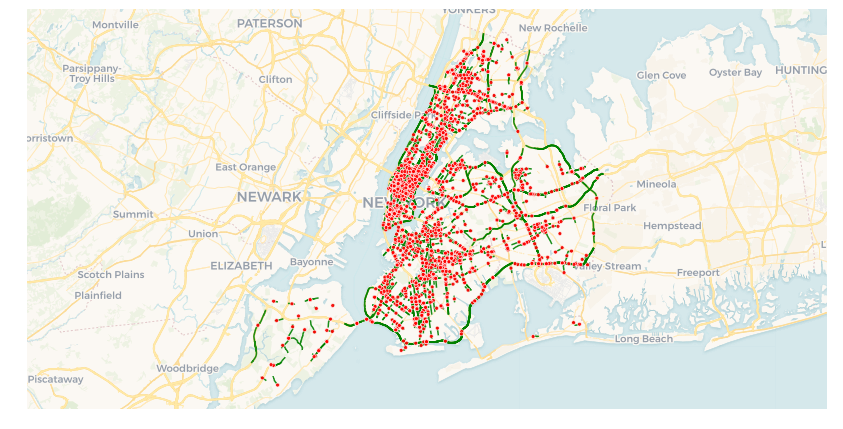

In [ ]:
cc.map(layers=[cartoframes.Layer('flatten_jams_collisions',
                                 color='green'),
               cartoframes.Layer('collisions_during_jams',
                                  color='red',
                                  size=4)],
      interactive=False)

### 6.3 Fatality/injury rates of collisions during jams

<a id='6.3'></a>

In [ ]:
jam_injur = jam_collisions[['number_of_cyclist_injured',
       'number_of_cyclist_killed',
       'number_of_motorist_injured',
       'number_of_motorist_killed',
       'number_of_pedestrians_injured',
       'number_of_pedestrians_killed']].sum()/len(jam_collisions)

In [ ]:
nonjam_injur = nonjam_collisions[['number_of_cyclist_injured',
       'number_of_cyclist_killed',
       'number_of_motorist_injured',
       'number_of_motorist_killed',
       'number_of_pedestrians_injured',
       'number_of_pedestrians_killed']].sum()/len(nonjam_collisions)

In [ ]:
n_groups = 6
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4

rects1 = ax.bar(index, nonjam_injur, bar_width,
                alpha=opacity, color='b',
                label='Collisions outside of jams')

rects2 = ax.bar(index + bar_width, jam_injur, bar_width,
                alpha=opacity, color='r',
                label='Collisions during jams')

ax.set_xlabel('Injury or Fatality', fontsize=14)
ax.set_ylabel('Rate', fontsize=14)
ax.set_title('Rates of Injury and Fatalities', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(('Cyclists Injured', 'Cyclists Killed', 'Motorists Injured', 'Motorists Killed', 'Pedestrians Injured', 'Pedestrianed Killed'), fontsize=14)
ax.legend(fontsize=12)

plt.tight_layout()
plt.xticks(rotation=45)
# plt.savefig('rates_injuries_fatalities.png')
plt.show()

# 6.3 ARIMA MODEL